In [1]:
import numpy as np
import sys, os
%matplotlib inline
import matplotlib.pyplot as plt
sys.path.append(os.environ['raco'])
sys.path.append(os.environ['rapl'])
sys.path.append(os.environ['rapl'] + '/timetrace')
sys.path.append(os.environ['rapp'])
from rayleigh_diagnostics import Shell_Slices
from common import *
labelsize = 8
from plotcommon import *

from timey_util import plot_timey

In [2]:
#dirname = '/altair/loma3853/public/tspec/'
dirname = '/nobackup/lmatilsk/case_M_tspec-orig/'
datadir = dirname + '/data/'
the_file = get_widest_range_file(datadir, 'AZ_Avgs')
print ('reading ' + the_file)
di = get_dict(the_file)
vals = di['vals']
lut = di['lut']
np.shape(vals)

reading /nobackup/lmatilsk/case_M_tspec-orig//data/AZ_Avgs-13652500_27350000.pkl


(384, 192, 294)

In [3]:
gi = get_grid_info(dirname)
rr = gi['rr']
nr = len(rr)
nphi = gi['nphi']
tw = gi['tw']
tw_2d = gi['tw_2d']
nt = len(tw)
tt_lat = gi['tt_lat']
sint = gi['sint']
print('nr =', nr)
print('nt =', nt)
print('nphi =', nphi)

nr = 192
nt = 384
nphi = 768


In [4]:
# indices associated with shell slices
radlevs = get_slice_levels(dirname)
rvals = radlevs.radius/rsun
rinds = []
for rval in rvals:
    rinds.append(np.argmin(np.abs(rr/rsun - rval)))
rinds = np.array(rinds)
print ("rvals =", rvals)
print ("rinds =", rinds)
print ("rr[rinds]/rsun =", rr[rinds]/rsun)

rvals = [0.71656272 0.70707956 0.6906394  0.66109085 0.63447754 0.6034544
 0.57752866 0.5476774  0.51833426 0.50226305]
rinds = [ 72  84  98 136 146 154 160 167 175 181]
rr[rinds]/rsun = [0.71656272 0.70707956 0.6906394  0.66109085 0.63447754 0.6034544
 0.57752866 0.5476774  0.51833426 0.50226305]


Text(0.5, 1.0, 'r/rsun = 0.691')

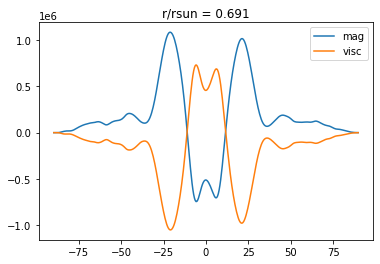

In [24]:
# magnetic torque
ir0 = 2

torque_v = vals[:, :, lut[1804]]
torque_mm = vals[:, :, lut[1805]]
torque_ms = vals[:, :, lut[1806]]
vp = vals[:, :, lut[3]]
diffrot = vp/gi['xx']/2/np.pi*1e9 # DR in nHz

torque_mag = torque_ms + torque_mm 
plt.figure()
plt.plot(tt_lat, torque_mag[:, rinds[ir0]], label='mag')
plt.plot(tt_lat, torque_v[:, rinds[ir0]], label='visc')
plt.legend()
plt.title('r/rsun = %.3f' %(rr[rinds[ir0]]/rsun))

In [25]:
# read in time m spectra from shell slices
datadir_tmspec = datadir + '/tmspec_mmax010/'

the_file = get_widest_range_file(datadir_tmspec, 'tmspec_qval3306_irval%02i' %ir0)
print ('reading ' + the_file)
di_tspec = get_dict(the_file)
mvals = di_tspec['mvals']
freq = di_tspec['freq']
bphi_dr = di_tspec['vals']

the_file = get_widest_range_file(datadir_tmspec, 'tmspec_qval3308_irval%02i' %ir0)
print ('reading ' + the_file)
bphi_dt = get_dict(the_file)['vals']

the_file = get_widest_range_file(datadir_tmspec,'tmspec_qval0801_irval%02i' %ir0)
print ('reading ' + the_file)
br = get_dict(the_file)['vals']

the_file = get_widest_range_file(datadir_tmspec,'tmspec_qval0802_irval%02i' %ir0)
print ('reading ' + the_file)
bt = get_dict(the_file)['vals']

the_file = get_widest_range_file(datadir_tmspec,'tmspec_qval0803_irval%02i' %ir0)
print ('reading ' + the_file)
bp = get_dict(the_file)['vals']

print (np.shape(bt))

reading /nobackup/lmatilsk/case_M_tspec-orig//data//tmspec_mmax010/tmspec_qval3306_irval02-13651000_27350000.pkl
reading /nobackup/lmatilsk/case_M_tspec-orig//data//tmspec_mmax010/tmspec_qval3308_irval02-13651000_27350000.pkl
reading /nobackup/lmatilsk/case_M_tspec-orig//data//tmspec_mmax010/tmspec_qval0801_irval02-13651000_27350000.pkl
reading /nobackup/lmatilsk/case_M_tspec-orig//data//tmspec_mmax010/tmspec_qval0802_irval02-13651000_27350000.pkl
reading /nobackup/lmatilsk/case_M_tspec-orig//data//tmspec_mmax010/tmspec_qval0803_irval02-13651000_27350000.pkl
(13700, 10, 384)


In [26]:
# get the torque by summing over frequency and m
ntimes, nm, nt = np.shape(bt)
nphi = 768
def summ(arr):
    return arr[0,...] + 2*np.sum(arr[1:,...],axis=0)
torque_spec = np.real(np.conjugate(br)*bphi_dr + np.conjugate(bt)*bphi_dt)/(ntimes*nphi)**2
torque_spec_tot = summ(np.sum(torque_spec,axis=0))

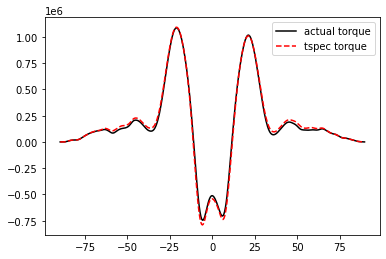

In [27]:
plt.figure()
plt.plot(tt_lat, torque_mag[:, rinds[ir0]], 'k', label='actual torque')
plt.plot(tt_lat, torque_spec_tot, 'r--', label='tspec torque')
plt.legend()

In [28]:
# nice! Now figure out how much torque comes from different m modes
# "prod[1:nfreq, 1:nm, 1:ntheta]" represents the torque at theta coming from different
# freq, m components

In [29]:
#lat0 = 0.
#ith0 = np.argmin(np.abs(tt_lat - lat0))
#tau_tot0 = tau_tot[ith0, rinds[ir0]]
torque_spec_m = np.sum(torque_spec, axis=0)
torque_spec_m[1:, :] *= 2
torque_spec_freq = np.zeros((ntimes, nt))
for ifreq in range(ntimes):
    torque_spec_freq[ifreq, ...] = summ(torque_spec[ifreq, ...])

In [30]:
print (np.shape(torque_spec_m))
print (np.shape(torque_spec_freq))

(10, 384)
(13700, 384)


In [31]:
# let's also look at the differential rotation -- a line plot of how much it varies (it covers substantial
# torsional oscillation over four dynamo cycles)
the_file = get_widest_range_file(datadir_tmspec.replace('tmspec', 'mtrace'), 'mtrace_qval0003_irval%02i' %ir0)
print ('reading ' + the_file)
di = get_dict(the_file)
vp_trace = np.real(di['vals'][:, 0, :])/nphi
print(np.shape(vp_trace))

reading /nobackup/lmatilsk/case_M_tspec-orig//data//mtrace_mmax010/mtrace_qval0003_irval02-13651000_27350000.pkl
(13700, 384)


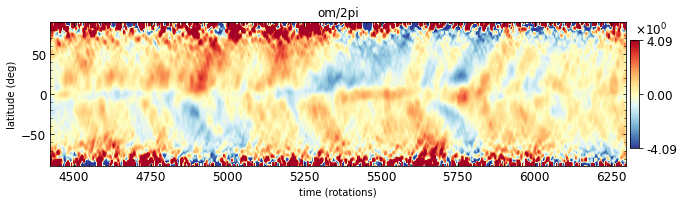

In [32]:
#Plot the diff. rot.
diffrot_trace = vp_trace/radlevs.radius[ir0]/sint.reshape((1, nt))/2/np.pi*1e9
diffrot_mean = np.mean(diffrot_trace, axis=0)
fig, axs, fpar = make_figure(sub_width_inches=8, sub_height_inches=2, margin_right_inches=3/4,\
                            margin_top_inches=1/4)
ax = axs[0, 0]
ax.set_xlabel('time (rotations)')
ax.set_ylabel('latitude (deg)')
ax.set_title('om/2pi')
ntot=500
prot = 2*np.pi/8.61e-6
times = di['times']/prot
t_thin = thin_data(times, ntot)
field = thin_data(diffrot_trace - diffrot_mean.reshape((1, nt)), ntot)
plot_timey(field, t_thin, tt_lat, fig, ax)

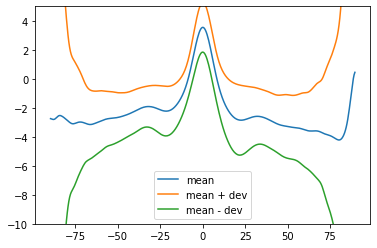

In [33]:
# make line plots
# maybe do standard deviation instead of min / max
nsigma = 2
diffrot_dev = np.zeros(nt)
for it in range(nt):
    diffrot_loc = diffrot_trace[:, it]
    diffrot_dev[it] = np.std(diffrot_loc)
plt.figure()
plt.plot(tt_lat, diffrot_mean, label='mean')
plt.plot(tt_lat, diffrot_mean + nsigma*diffrot_dev, label='mean + dev')
plt.plot(tt_lat, diffrot_mean - nsigma*diffrot_dev, label='mean - dev')
plt.ylim(-10,5)
plt.legend()

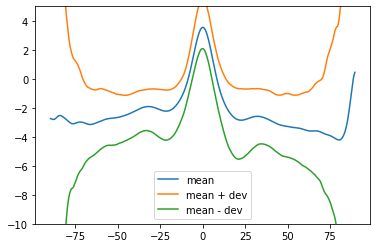

In [34]:
# quick try normalizing positive and negative separately 
nsigma = 2
diffrot_dev_minus = np.zeros(nt)
diffrot_dev_plus = np.zeros(nt)
for it in range(nt):
    diffrot_loc = diffrot_trace[:, it]
    diffrot_loc -= np.mean(diffrot_loc) # subtract out mean
    diffrot_dev_plus[it] = rms(diffrot_loc[np.where(diffrot_loc>0)])
    diffrot_dev_minus[it] = rms(diffrot_loc[np.where(diffrot_loc<0)])
plt.figure()
plt.plot(tt_lat, diffrot_mean, label='mean')
plt.plot(tt_lat, diffrot_mean + nsigma*diffrot_dev_plus, label='mean + dev')
plt.plot(tt_lat, diffrot_mean - nsigma*diffrot_dev_minus, label='mean - dev')
plt.ylim(-10,5)
plt.legend()

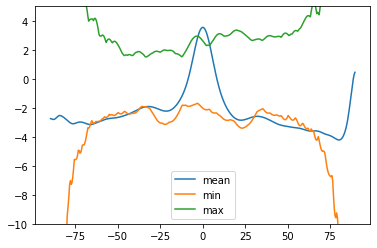

In [35]:
# try min/max too
nsigma = 1
diffrot_min = np.zeros(nt)
diffrot_max = np.zeros(nt)
for it in range(nt):
    diffrot_min[it] = np.min(diffrot_trace[:, it])
    diffrot_max[it] = np.max(diffrot_trace[:, it])
plt.figure()
plt.plot(tt_lat, diffrot_mean, label='mean')
plt.plot(tt_lat, diffrot_min, label='min')
plt.plot(tt_lat, diffrot_max, label='max')
plt.ylim(-10,5)
plt.legend()

In [36]:
# figure dimensions

# Set up the actual figure from scratch
fig_width_inches = 4.75 # TOTAL figure width, in inches
margin_inches = 1/16 # margin width in inches (for both x and y) and 
    # horizontally in between figures
margin_bottom_inches = 3/8
    # larger bottom margin to make room for colorbar
margin_top_inches = 1/4# wider top title
margin_left_inches = 5/8 # wider top title
margin_right_inches = 1/2 # wider top title

#full_width_inches = (fig_width_inches - 2*margin_left_inches - 2*margin_right_inches)
lineplot_width_inches = 2.#full_width_inches/2
subplot_height_inches = 1.7

spec_width_inches = (fig_width_inches - margin_left_inches - margin_right_inches - margin_inches)/2

#lineplot_aspect = 3/4
# set the height of the panels to track the aspect ratio for the lineplot
#subplot_height_inches = lineplot_width_inches*lineplot_aspect 

fig_height_inches = 2*(subplot_height_inches + margin_bottom_inches + margin_top_inches)

# "Margin" in "figure units"; figure units extend from 0 to 1 in BOTH 
# directions, so unitless dimensions of margin will be different in x and y
# to force an equal physical margin
margin_x = margin_inches/fig_width_inches
margin_y = margin_inches/fig_height_inches
margin_top = margin_top_inches/fig_height_inches
margin_bottom = margin_bottom_inches/fig_height_inches
margin_left = margin_left_inches/fig_width_inches
margin_right = margin_right_inches/fig_width_inches

# Subplot dimensions in figure units
lineplot_width = lineplot_width_inches/fig_width_inches
spec_width = spec_width_inches/fig_width_inches
#full_width = full_width_inches/fig_width_inches
# common height
subplot_height = subplot_height_inches/fig_height_inches 

print ("fig size: ", fig_width_inches, fig_height_inches)
print ("line plot size: ", lineplot_width_inches, subplot_height_inches)
print ("spec size: ", spec_width_inches, subplot_height_inches)

fig size:  4.75 4.65
line plot size:  2.0 1.7
spec size:  1.78125 1.7


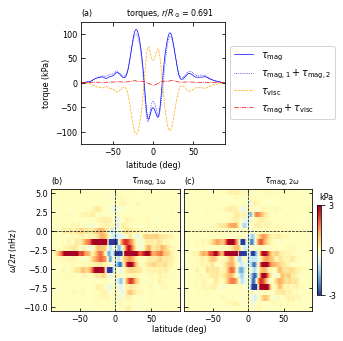

In [18]:
# Generate the actual figure of the correct dimensions
fig = plt.figure(figsize=(fig_width_inches, fig_height_inches))

# make axes
mmin, mmax = 1,2
fs = 6
ax1 = fig.add_axes((margin_left + 0.5*(1 - margin_left - margin_right) - 0.7*lineplot_width,\
                    1 - margin_top - subplot_height, lineplot_width, subplot_height))
ax2 = fig.add_axes((margin_left, margin_bottom, spec_width, subplot_height))
ax3 = fig.add_axes((margin_left + spec_width + margin_x, margin_bottom, spec_width, subplot_height))

# plot the torque at r = 0.691
linewidth = 0.7
plt.sca(ax1)
plt.plot(tt_lat, torque_mag[:, rinds[ir0]]/1e6, 'b-', label=r'$\tau_{\rm{mag}}$', linewidth=linewidth)
plt.plot(tt_lat, np.sum(torque_spec_m[mmin:mmax+1,:], axis=0), 'b:',\
         label=r'$\tau_{\rm{mag,1}}+\tau_{\rm{mag,2}}$', linewidth=linewidth)
plt.plot(tt_lat, torque_v[:, rinds[ir0]]/1e6, label=r'$\tau_{\rm{visc}}$', color='orange',\
         linestyle='--', linewidth=linewidth)
plt.plot(tt_lat, (torque_v + torque_mag)[:, rinds[ir0]]/1e6,'r-.',\
         label=r'$\tau_{\rm{mag}} + \tau_{\rm{visc}}$', linewidth=linewidth)

plt.minorticks_off()
plt.tick_params(top=True, right=True, direction='in', which='both',labelsize=labelsize)
#plt.ticklabel_format(useMathText=True, axis='y', scilimits=(0,0))
plt.xlabel('latitude (deg)', fontsize=labelsize)
plt.xlim(-90, 90)
the_unit = r'$10^6\ \rm{dyn\ cm^{-2}}$'
plt.ylabel('torque (' + the_unit + ')', fontsize=labelsize)
plt.legend(fontsize=1.2*labelsize, ncol=1, loc='center left', bbox_to_anchor=(1, 0.5))

# make room for legend
#ax1.set_ylim(-250, 125)
ax1.set_ylim(-1.25, 1.25)

# plot the magnetic torque vs. frequency
#kw_my_pcolormesh.cmap = None

# m = 1
specmax = 0.03
freqmin, freqmax = -10, 5
my_pcolormesh((torque_spec[::-1, 1, :]).T/1e6, fig, ax2,\
    x=tt_lat, y=freq*1e9, yminmax=(freqmin, freqmax), posdef=False, fontsize=labelsize, plotcbar=False,\
              minmax=(-specmax, specmax))
#ax2.set_xlabel('latitude (deg)', fontsize=labelsize)
ax2.set_ylabel(r'$\omega/2\pi$' + ' (nHz)', fontsize=labelsize)

# deal with ticks
plt.sca(ax2)
plt.tick_params(top=True, right=True, direction='in', which='both', labelsize=labelsize)
plt.minorticks_off()
#plt.ticklabel_format(useMathText=True, axis='y', scilimits=(0,0))


# m = 2
my_pcolormesh((torque_spec[::-1, 2, :]).T/1e6, fig, ax3,\
    x=tt_lat, y=freq*1e9, yminmax=(freqmin, freqmax), posdef=False, fontsize=labelsize, cbar_pos='right',\
                          cbar_thick=1/16, cbar_aspect=1/20, cbar_fs=labelsize, nosci=True,\
                           cbar_prec=0, units=, minmax=(-specmax, specmax))
#ax3.set_xlabel('latitude (deg)', fontsize=labelsize)
#ax3.set_ylabel('frequency (nHz)', fontsize=labelsize)
ax3.set_yticklabels([])

# deal with ticks
plt.sca(ax3)
plt.tick_params(top=True, right=True, direction='in', which='both', labelsize=labelsize)
plt.minorticks_off()
#plt.ticklabel_format(useMathText=True, axis='y', scilimits=(0,0))


# put labels and titles on there
labels = ['(a)', '(b)', '(c)']
nspaces = 5
titles = ['torques, ' + (r'$r/R_\odot=%.3f$' %rvals[ir0]) + nspaces*' ',\
          r'$\tau_{\rm{mag,1\omega}}$' + nspaces*' ',\
         r'$\tau_{\rm{mag,2\omega}}$' + nspaces*' ']

iplot = 0
for ax in [ax1, ax2, ax3]:
    if iplot == 0:
        fs = labelsize
    else:
        fs = 1.2*labelsize
    ax.set_title(labels[iplot], loc='left', fontsize=labelsize)
    ax.set_title(titles[iplot], loc='right', fontsize=fs)
    iplot += 1

# add zero lines for frequency
for ax in [ax2, ax3]:
    ax.plot(tt_lat, tt_lat*0, 'k--', linewidth=linewidth)
    freqvals = np.linspace(freqmin, freqmax, 100)
    ax.plot(np.zeros(100), freqvals, 'k--', linewidth=linewidth)

iplot = 0
nsigma = 2
#for ax in [ax2, ax3]:
for ax in []:
    ax.plot(tt_lat, tt_lat*0, 'k--', linewidth=linewidth)

    # plot the differential rotation too, and its deviation
    
    # also cut off the latitude because the poles go crazy
    latcut = 60.
    icut1, icut2 = np.argmin(np.abs(tt_lat+latcut)), np.argmin(np.abs(tt_lat-latcut))
    ax.plot(tt_lat[icut1:icut2+1], diffrot_mean[icut1:icut2+1]*(iplot+1), 'k:', linewidth=2*linewidth)
    #ax.plot(tt_lat[icut1:icut2+1], diffrot_min[icut1:icut2+1]*(iplot+1), 'k:', linewidth=1*linewidth)
    #ax.plot(tt_lat[icut1:icut2+1], diffrot_max[icut1:icut2+1]*(iplot+1), 'k:', linewidth=1*linewidth)
    ax.plot(tt_lat[icut1:icut2+1], (diffrot_mean + nsigma*diffrot_dev)[icut1:icut2+1]*(iplot+1),\
            'k:', linewidth=1*linewidth)
    ax.plot(tt_lat[icut1:icut2+1], (diffrot_mean - nsigma*diffrot_dev)[icut1:icut2+1]*(iplot+1),\
            'k:', linewidth=1*linewidth)
    iplot += 1

# add latitude label for ax2, ax3
fig.text(margin_left + 0.5*(1 - margin_left - margin_x - margin_right),\
        margin_y, 'latitude (deg)', fontsize=labelsize, va='bottom', ha='center')
    
plt.savefig('images/magtorque_freq.png', dpi=300)
# make lineplot

In [19]:
np.shape(torque_spec)

(13700, 10, 384)

In [20]:
torque_spec[0,0,0]

1.2508011567988902e-11

In [21]:
# Nyquist frequency
np.max(np.abs(freq))

4.999999999999998e-06

In [22]:
# get the first and last rotations for the slice
print ("t1 = ", times[0])
print ("t2 = ", times[-1])

t1 =  4421.7763762269215
t2 =  6298.98330604999
